### Stock Market Prediction And Forecasting Using Stacked LSTM

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
### Data Collection
import pandas_datareader as pdr
key="eeeb3a6e5c1f42f59906cc00309b78393a93c9db"

In [3]:
df = pdr.get_data_tiingo('AAPL', api_key=key)

In [4]:
df.to_csv('AAPL.csv')

In [5]:
import pandas as pd

In [6]:
df=pd.read_csv('AAPL.csv')

In [7]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2016-04-21 00:00:00+00:00,105.97,106.93,105.52,106.93,31552525,24.636619,24.859807,24.532000,24.859807,126210100,0.0,1.0
1,AAPL,2016-04-22 00:00:00+00:00,105.68,106.48,104.62,105.01,33683121,24.569198,24.755188,24.322762,24.413432,134732484,0.0,1.0
2,AAPL,2016-04-25 00:00:00+00:00,105.08,105.65,104.51,105.00,28031588,24.429706,24.562224,24.297189,24.411107,112126352,0.0,1.0
3,AAPL,2016-04-26 00:00:00+00:00,104.35,105.30,103.91,103.91,56016165,24.259991,24.480853,24.157697,24.157697,224064660,0.0,1.0
4,AAPL,2016-04-27 00:00:00+00:00,97.82,98.71,95.68,96.00,114602142,22.741853,22.948766,22.244331,22.318727,458408568,0.0,1.0


In [8]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1252,AAPL,2021-04-13 00:00:00+00:00,134.43,134.66,131.930,132.44,91266545,134.43,134.66,131.930,132.44,91266545,0.0,1.0
1253,AAPL,2021-04-14 00:00:00+00:00,132.03,135.00,131.655,134.94,87222782,132.03,135.00,131.655,134.94,87222782,0.0,1.0
1254,AAPL,2021-04-15 00:00:00+00:00,134.50,135.00,133.640,133.82,89347102,134.50,135.00,133.640,133.82,89347102,0.0,1.0
1255,AAPL,2021-04-16 00:00:00+00:00,134.16,134.67,133.280,134.30,84922386,134.16,134.67,133.280,134.30,84922386,0.0,1.0
1256,AAPL,2021-04-19 00:00:00+00:00,134.84,135.47,133.340,133.51,94264215,134.84,135.47,133.340,133.51,94264215,0.0,1.0


In [9]:
df1=df.reset_index()['close']

In [10]:
df1

0       105.97
1       105.68
2       105.08
3       104.35
4        97.82
         ...  
1252    134.43
1253    132.03
1254    134.50
1255    134.16
1256    134.84
Name: close, Length: 1257, dtype: float64

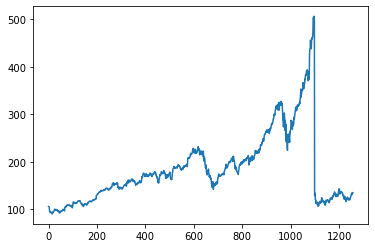

In [11]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [12]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [13]:
import numpy as np

In [14]:
df1

0       105.97
1       105.68
2       105.08
3       104.35
4        97.82
         ...  
1252    134.43
1253    132.03
1254    134.50
1255    134.16
1256    134.84
Name: close, Length: 1257, dtype: float64

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [16]:
print(df1)

[[0.03759471]
 [0.03689717]
 [0.035454  ]
 ...
 [0.10621768]
 [0.10539988]
 [0.10703548]]


In [17]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [18]:
training_size,test_size

(817, 440)

In [19]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [20]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [21]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [22]:
print(X_test.shape), print(ytest.shape)

(339, 100)
(339,)


(None, None)

In [23]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [24]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [25]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 11s 289ms/step - loss: 0.0181 - val_loss: 0.0419
Epoch 2/100
12/12 [==============================] - 0s 40ms/step - loss: 0.0026 - val_loss: 0.0226
Epoch 3/100
12/12 [==============================] - 0s 39ms/step - loss: 0.0014 - val_loss: 0.0240
Epoch 4/100
12/12 [==============================] - 0s 40ms/step - loss: 6.6405e-04 - val_loss: 0.0198
Epoch 5/100
12/12 [==============================] - 0s 39ms/step - loss: 4.7467e-04 - val_loss: 0.0190
Epoch 6/100
12/12 [==============================] - 0s 39ms/step - loss: 3.8002e-04 - val_loss: 0.0189
Epoch 7/100
12/12 [==============================] - 0s 40ms/step - loss: 3.4248e-04 - val_loss: 0.0182
Epoch 8/100
12/12 [==============================] - 0s 39ms/step - loss: 3.4647e-04 - val_loss: 0.0176
Epoch 9/100
12/12 [==============================] - 0s 39ms/step - loss: 3.0831e-04 - val_loss: 0.0174
Epoch 10/100
12/12 [==============================] - 0s 40ms/step - loss:

In [28]:
tf.__version__

'2.4.1'

In [29]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [38]:
test_predict.shape

(339, 1)

In [30]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [31]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

168.52295279945469

In [32]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

238.65018466537524

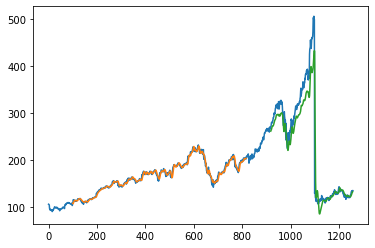

In [33]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [34]:
len(test_data)

440

In [35]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape


(1, 99)

In [36]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [37]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

ValueError: cannot reshape array of size 99 into shape (1,100,1)

In [442]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [443]:
import matplotlib.pyplot as plt

In [391]:
len(df1)

1258

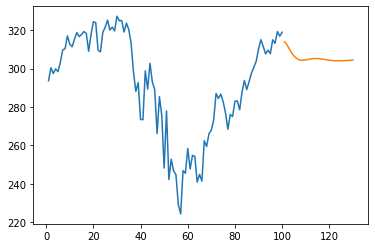

In [444]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

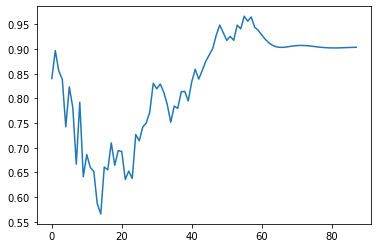

In [446]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [395]:
df3=scaler.inverse_transform(df3).tolist()

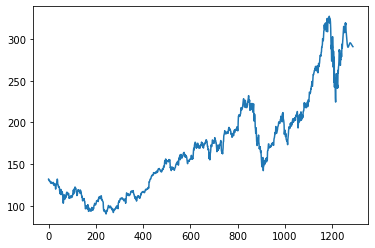

In [396]:
plt.plot(df3)